%conda install -c conda-forge torchgeo pytorch torchvision pycocotools
%conda install -c anaconda scikit-learn

In [1]:
import os
import torch
import numpy as np
from torch.utils.data import DataLoader, random_split
from torch import nn, optim
import matplotlib.pyplot as plt
from torchvision.transforms import functional as F
from torchvision import transforms
from torchvision.models.segmentation import deeplabv3_resnet50  # Modelo de segmentación
from torchvision.models.detection import fasterrcnn_resnet50_fpn  # Modelo de detección de objetos
from PIL import Image
from pycocotools.coco import COCO
from torchgeo.datasets import GeoDataset
from torchvision.transforms import v2


In [10]:
import os
import numpy as np
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms.functional as F
from pycocotools.coco import COCO
import albumentations as A
from albumentations.pytorch import ToTensorV2
import matplotlib.pyplot as plt
import copy


In [3]:
print("Workers disponibles: ", os.cpu_count())
#num_workers = 12
num_workers = 0
batch_size = 17
num_epochs = 5
n_classes = 3

Workers disponibles:  8


In [15]:
# Definir el dataset COCO
class CocoDataset(Dataset):
    def __init__(self, root, annFile, transform=None):
        self.coco = COCO(annFile)
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.root = root
        self.transform = transform

    def __getitem__(self, index: int):
        coco_id = self.ids[index]
        coco_img = self.coco.loadImgs(coco_id)[0]
        path = os.path.join(self.root, coco_img['file_name'])
        img = np.array(Image.open(path).convert('RGB'))

        mask = np.zeros((coco_img['height'], coco_img['width']), dtype=np.uint8)
        annIds = self.coco.getAnnIds(imgIds=coco_img['id'], iscrowd=None)
        anns = self.coco.loadAnns(annIds)
        for ann in anns:
            mask += self.coco.annToMask(ann)

        if self.transform:
            augmented = self.transform(image=img, mask=mask)
            img = augmented['image']
            mask = augmented['mask']

        return img, mask

    def __len__(self):
        return len(self.ids)

In [42]:
# Definir las transformaciones
class MyTransform:
    def __init__(self, size, mean=None, std=None):
        self.transform = A.Compose([
            A.RandomResizedCrop(height=size[0], width=size[1], scale=(0.8, 1.0)),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=45, p=0.5),
            A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            A.GaussianBlur(blur_limit=3, p=0.5),
            A.GaussNoise(var_limit=(10.0, 50.0), p=0.5),
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
            A.CoarseDropout(max_holes=8, max_height=8, max_width=8, fill_value=0, p=0.5),
            #A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
            A.Normalize(mean=mean, std=std),
            ToTensorV2()
        ])

    def __call__(self, image, mask):
        transformed = self.transform(image=image, mask=mask)
        return {'image': transformed['image'], 'mask': transformed['mask']}


In [68]:
def visualize_augmentations(dataset, idx=0, samples=5, classes=None):
    dataset = copy.deepcopy(dataset)
    
    figure, ax = plt.subplots(nrows=samples, ncols=3, figsize=(15, 5 * samples))

    for i in range(samples):
        img, mask = dataset[idx]  # Obtiene la imagen original y la máscara

        # Convierte imagen y máscara a formato adecuado si son tensores de PyTorch
        if isinstance(img, torch.Tensor):
            img = img.permute(1, 2, 0).numpy()  # Cambia de C, H, W a H, W, C
        if isinstance(mask, torch.Tensor):
            mask = mask.numpy()  # Convierte la máscara tensor a NumPy array si es necesario

        # Normaliza la imagen para visualización
        img = (img - img.min()) / (img.max() - img.min())

        # Muestra la imagen original
        ax[i, 0].imshow(img)
        ax[i, 0].set_title("Original Image")
        ax[i, 0].set_axis_off()

        # Intenta obtener las transformaciones de MyTransform
        if hasattr(dataset.transform, 'transform') and hasattr(dataset.transform.transform, 'transforms'):
            transformations = dataset.transform.transform.transforms
        else:
            transformations = [dataset.transform]  # Si no es iterable, usa el transformador como una lista única

        # Aplica cada transformación por separado y registra la transformación aplicada
        for transform in transformations:
            if isinstance(transform, (A.Normalize, ToTensorV2)):
                continue  # Ignora la normalización y ToTensor para la visualización
            transformed = transform(image=img.copy(), mask=mask.copy())
            img_augmented = transformed['image']
            mask_augmented = transformed['mask']

            # Normaliza la imagen aumentada para visualización
            img_augmented = (img_augmented - img_augmented.min()) / (img_augmented.max() - img_augmented.min())

            # Muestra la imagen aumentada
            ax[i, 1].imshow(img_augmented)
            ax[i, 1].set_title(f"Augmented Image - {type(transform).__name__}")  # Muestra el nombre de la transformación
            ax[i, 1].set_axis_off()

            # Extrae la clase de la máscara, si se proporciona el mapeo de clases
            mask_class_id = np.max(mask_augmented) if mask_augmented.size else 0
            mask_class = classes.get(mask_class_id, "Unknown Class") if classes else "Unknown Class"

            # Muestra la máscara aumentada
            ax[i, 2].imshow(mask_augmented, interpolation="nearest")
            ax[i, 2].set_title(f"Augmented Mask - {mask_class}")
            ax[i, 2].set_axis_off()

            

    plt.tight_layout()
    plt.show()

In [44]:
# Ajusta estos según tus rutas específicas
PATH = "/media/noobird/2002f002-8812-46a4-953d-1872302534b1/project-2-at-2024-06-17-17-54-839d4e00/images"
annotation_file = '/media/noobird/2002f002-8812-46a4-953d-1872302534b1/project-2-at-2024-06-17-17-54-839d4e00/result.json'
mean = [102.90952289767654 / 255, 82.80851821508439 / 255, 67.72829849206559 / 255]
std = [31.16809754527791 / 255, 27.179289019192897 / 255, 24.66894766822647 / 255]


In [19]:
size = (512, 512)

In [45]:
# Instancia del dataset y transformaciones
transform = MyTransform(size=size, mean=mean, std=std)
dataset = CocoDataset(root=PATH, annFile=annotation_file, transform=transform)
# Ejemplo de acceso a una muestra del dataset
img, mask = dataset[0]

print(img.shape, mask.shape)

loading annotations into memory...
Done (t=0.09s)
creating index...
index created!
torch.Size([3, 512, 512]) torch.Size([512, 512])


/tmp/ipykernel_86361/2326862884.py:38: RuntimeWarning: invalid value encountered in divide
  img_augmented = (img_augmented - img_augmented.min()) / (img_augmented.max() - img_augmented.min())


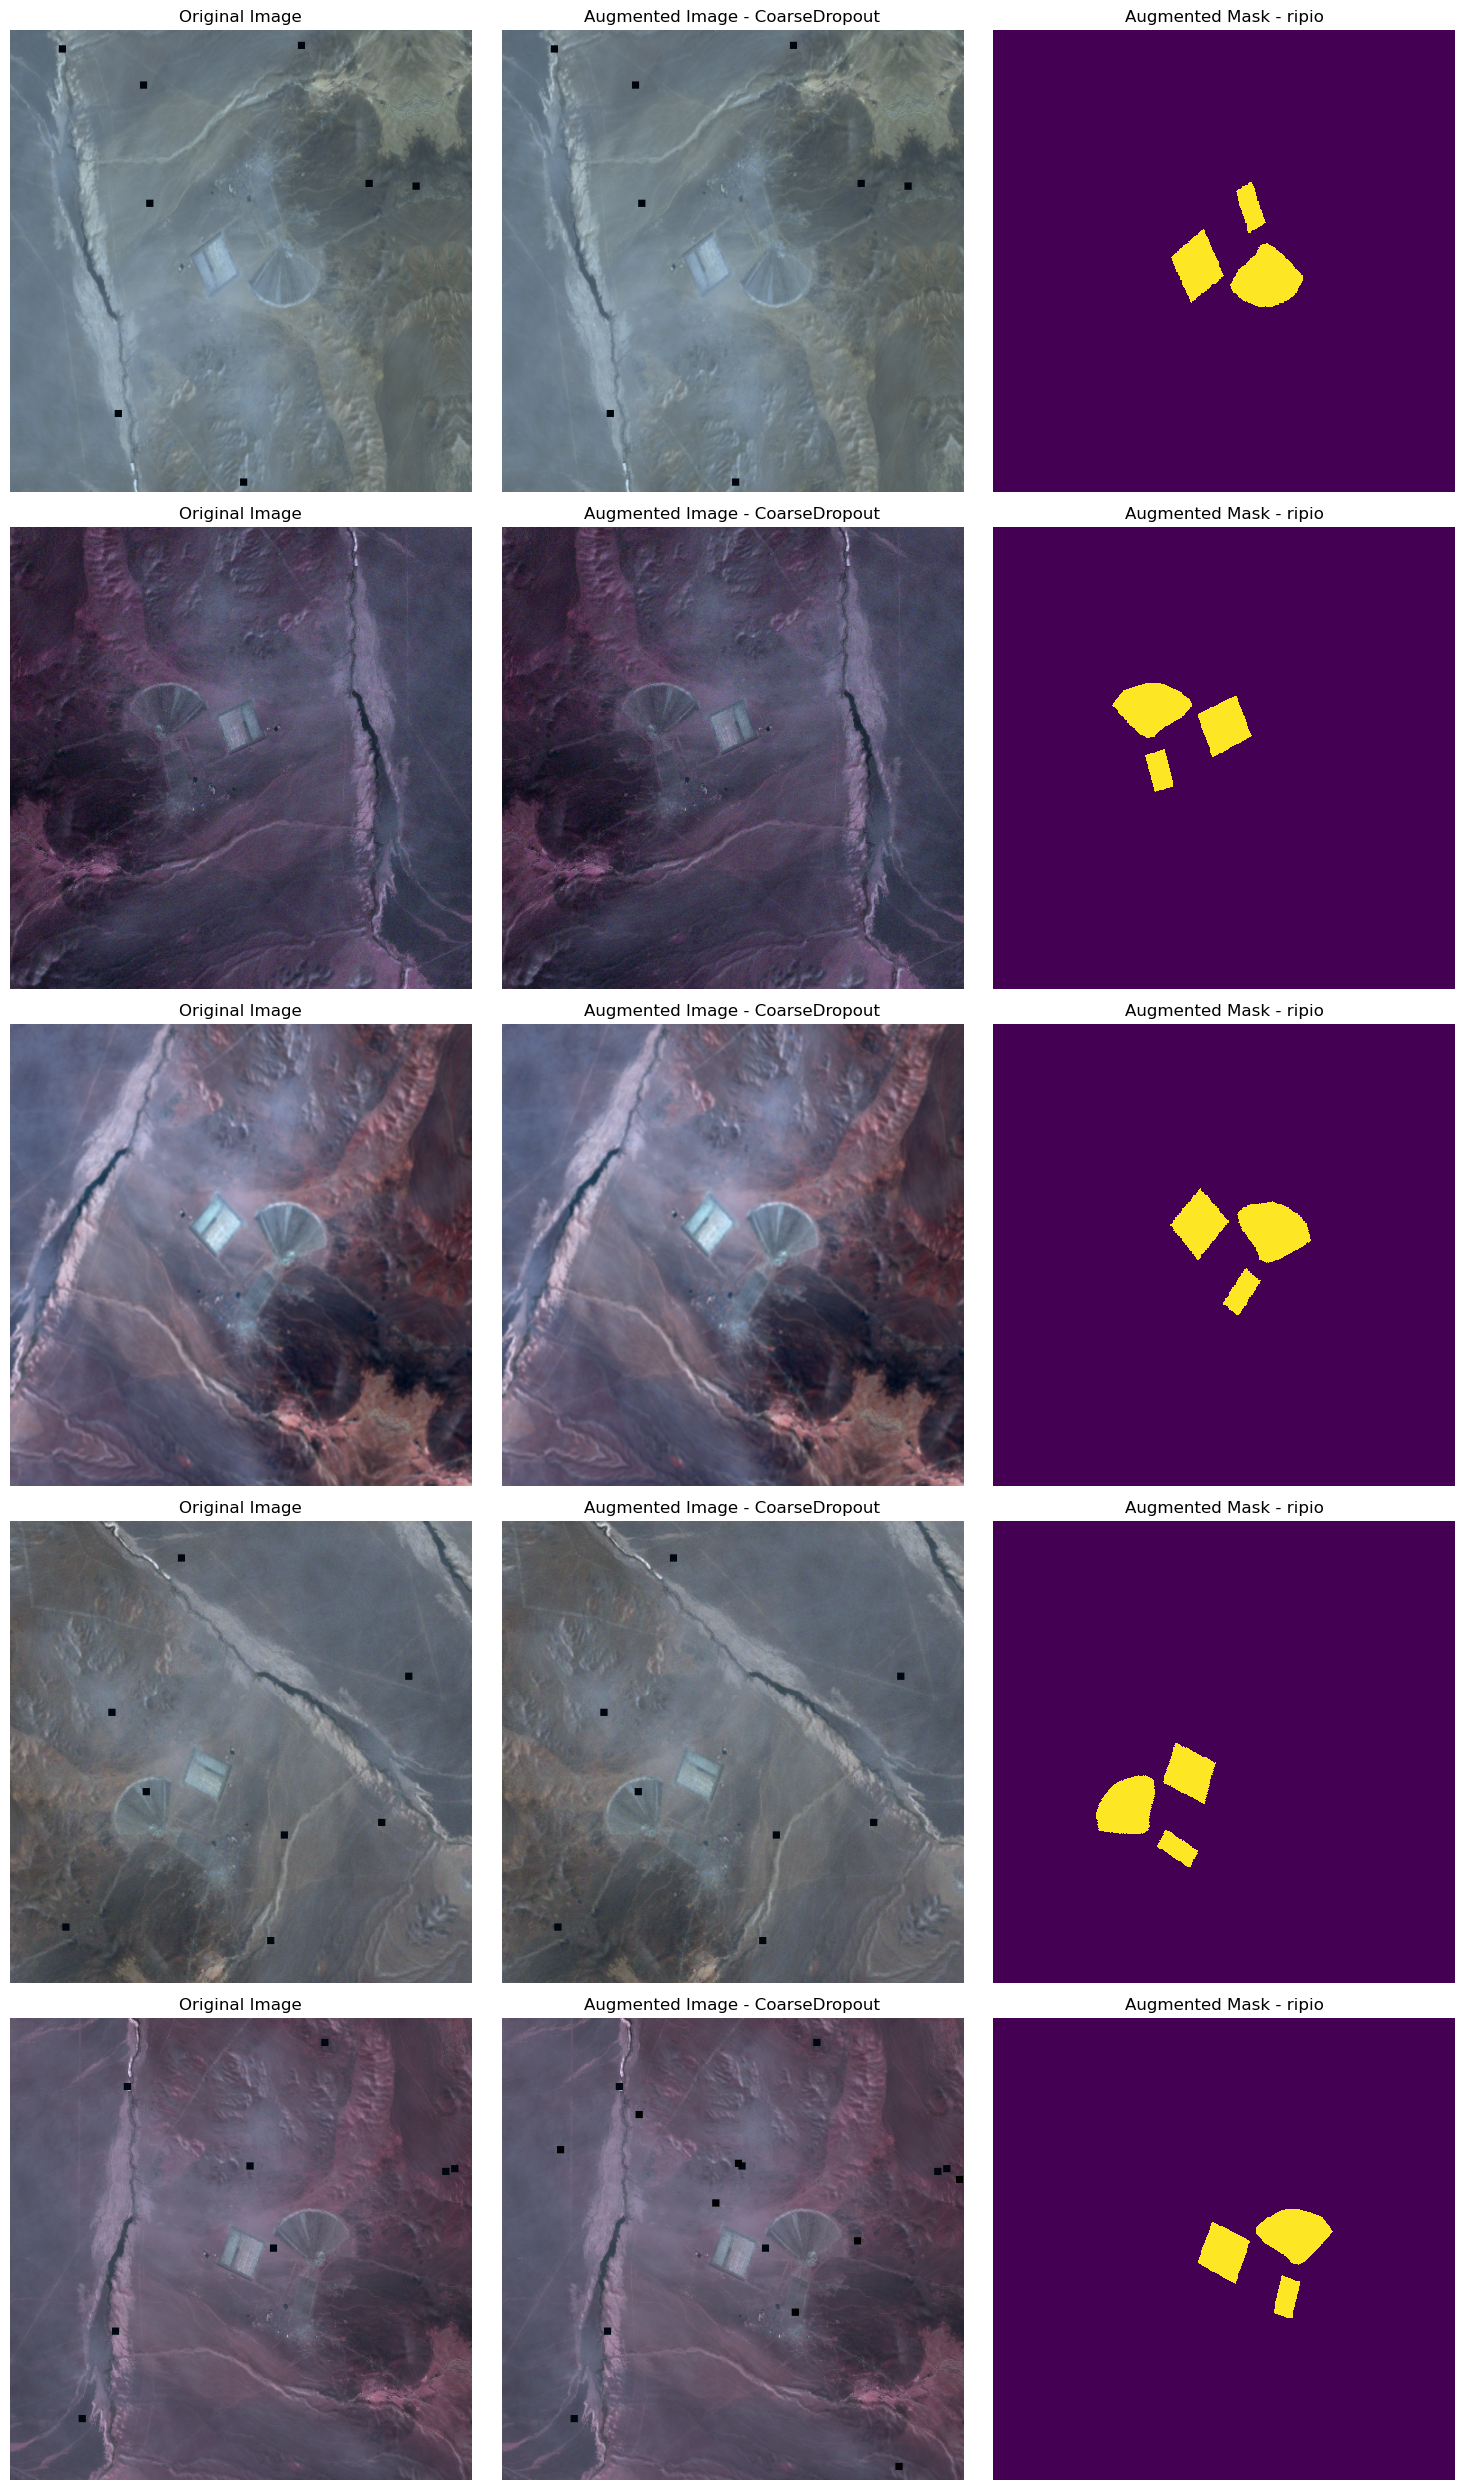

In [70]:
visualize_augmentations(dataset, idx=1, samples=5, classes={0: 'bem', 1: 'ripio', 2: 'tranque'})

In [6]:

# Particionar el dataset
total_size = len(coco_dataset)
train_size = int(0.7 * total_size)
val_size = total_size - train_size
train_dataset, val_dataset = random_split(coco_dataset, [train_size, val_size])

# Crear DataLoaders
train_loader = DataLoader(train_dataset, num_workers=num_workers, batch_size=batch_size, shuffle=True, pin_memory=True)
val_loader = DataLoader(val_dataset, num_workers=num_workers, batch_size=batch_size, shuffle=False, pin_memory=True)

# Definir el dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

loading annotations into memory...
Done (t=10.67s)
creating index...
index created!


In [7]:
# Elegir el modelo
# Para segmentación semántica

# Elegir el modelo
model = deeplabv3_resnet50(pretrained=False, num_classes=n_classes).to(device)

# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

/home/robotica10/anaconda3/envs/eff2/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/robotica10/anaconda3/envs/eff2/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [8]:
# Función para entrenar una época
def train_one_epoch(model, train_loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    for images, masks in train_loader:
        images, masks = images.to(device), masks.to(device)
        masks = masks.long()  # Asegura que las máscaras sean de tipo long

        optimizer.zero_grad()
        outputs = model(images)['out']  # Para DeepLabV3

        # Asegúrate de que las máscaras tengan la misma forma que las salidas del modelo
        if len(masks.shape) == 4:
            masks = masks.squeeze(1)
        
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

# Función para validar una época
def validate(model, val_loader, criterion, device):
    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            masks = masks.long()
            outputs = model(images)['out']  # Para DeepLabV3
            
            if len(masks.shape) == 4:
                masks = masks.squeeze(1)
            
            loss = criterion(outputs, masks)
            running_val_loss += loss.item()
    return running_val_loss / len(val_loader)

In [9]:
import time

start_time = time.time()  # Iniciar el cronómetro

In [10]:
# Inicializar listas para almacenar las pérdidas
train_losses = []
val_losses = []

# Bucle de entrenamiento y validación
best_val_loss = float('inf')

for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss = validate(model, val_loader, criterion, device)
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Training Loss: {train_loss}, Validation Loss: {val_loss}')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
        print(f'Model saved: Epoch {epoch+1}, Validation Loss: {val_loss}')

/opt/conda/conda-bld/pytorch_1716905969118/work/aten/src/ATen/native/cuda/NLLLoss2d.cu:106: nll_loss2d_forward_kernel: block: [1,0,0], thread: [780,0,0] Assertion `t >= 0 && t < n_classes` failed.
/opt/conda/conda-bld/pytorch_1716905969118/work/aten/src/ATen/native/cuda/NLLLoss2d.cu:106: nll_loss2d_forward_kernel: block: [1,0,0], thread: [781,0,0] Assertion `t >= 0 && t < n_classes` failed.
/opt/conda/conda-bld/pytorch_1716905969118/work/aten/src/ATen/native/cuda/NLLLoss2d.cu:106: nll_loss2d_forward_kernel: block: [1,0,0], thread: [782,0,0] Assertion `t >= 0 && t < n_classes` failed.
/opt/conda/conda-bld/pytorch_1716905969118/work/aten/src/ATen/native/cuda/NLLLoss2d.cu:106: nll_loss2d_forward_kernel: block: [1,0,0], thread: [783,0,0] Assertion `t >= 0 && t < n_classes` failed.
/opt/conda/conda-bld/pytorch_1716905969118/work/aten/src/ATen/native/cuda/NLLLoss2d.cu:106: nll_loss2d_forward_kernel: block: [1,0,0], thread: [784,0,0] Assertion `t >= 0 && t < n_classes` failed.
/opt/conda/cond

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


In [ ]:
elapsed_time = time.time() - start_time  # Calcular el tiempo transcurrido
print(f"Tiempo de entrenamiento: {elapsed_time:.4f} segundos")

In [ ]:
# Graficar las pérdidas de entrenamiento y validación
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig('trainvalgraph.png', bbox_inches='tight')
plt.show()

In [ ]:
def binary_accuracy(preds, target):
    correct = (preds == target).float()
    acc = correct.sum() / correct.numel()
    return acc

def iou_score(preds, target):
    intersection = (preds & target).sum(dim=(1, 2))
    union = (preds | target).sum(dim=(1, 2))
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean()

def recall(preds, target):
    true_positive = (preds & target).sum()
    actual_positive = target.sum()
    rec = true_positive / (actual_positive + 1e-6)
    return rec

def precision(preds, target):
    true_positive = (preds & target).sum()
    predicted_positive = preds.sum()
    prec = true_positive / (predicted_positive + 1e-6)
    return prec

def evaluate_model(model, loader, device):
    model.eval()
    with torch.no_grad():
        all_accuracy, all_iou, all_recall, all_precision = [], [], [], []
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device).long()
            
            outputs = model(images)['out']
            outputs = torch.sigmoid(outputs)
            outputs = torch.argmax(outputs, dim=1)
            
            if outputs.shape != masks.shape:
                masks = masks.squeeze(1)
                
            all_accuracy.append(binary_accuracy(outputs, masks))
            all_iou.append(iou_score(outputs, masks))
            all_recall.append(recall(outputs, masks))
            all_precision.append(precision(outputs, masks))
        
        mean_accuracy = torch.mean(torch.stack(all_accuracy)).item()
        mean_iou = torch.mean(torch.stack(all_iou)).item()
        mean_recall = torch.mean(torch.stack(all_recall)).item()
        mean_precision = torch.mean(torch.stack(all_precision)).item()
        
        print(f'Accuracy: {mean_accuracy}, IoU: {mean_iou}')
        print(f'Recall: {mean_recall}, Precision: {mean_precision}')
        
    return mean_accuracy, mean_iou, mean_recall, mean_precision

# Llamar a la función de evaluación para el loader de validación o prueba
mean_accuracy, mean_iou, mean_recall, mean_precision = evaluate_model(model, val_loader, device)


In [ ]:
import torch
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def per_class_accuracy(preds, target, num_classes):
    acc = []
    for cls in range(num_classes):
        cls_pred = (preds == cls)
        cls_target = (target == cls)
        correct = (cls_pred & cls_target).sum().float()
        total = cls_target.sum().float()
        acc.append(correct / (total + 1e-6))
    return torch.tensor(acc)

def iou_score(preds, target, num_classes):
    iou = []
    for cls in range(num_classes):
        cls_pred = (preds == cls)
        cls_target = (target == cls)
        intersection = (cls_pred & cls_target).sum().float()
        union = (cls_pred | cls_target).sum().float()
        iou.append(intersection / (union + 1e-6))
    return torch.tensor(iou).mean()

def recall(preds, target, num_classes):
    recall = []
    for cls in range(num_classes):
        cls_pred = (preds == cls)
        cls_target = (target == cls)
        true_positive = (cls_pred & cls_target).sum().float()
        actual_positive = cls_target.sum().float()
        recall.append(true_positive / (actual_positive + 1e-6))
    return torch.tensor(recall).mean()

def precision(preds, target, num_classes):
    precision = []
    for cls in range(num_classes):
        cls_pred = (preds == cls)
        cls_target = (target == cls)
        true_positive = (cls_pred & cls_target).sum().float()
        predicted_positive = cls_pred.sum().float()
        precision.append(true_positive / (predicted_positive + 1e-6))
    return torch.tensor(precision)

def evaluate_model(model, loader, device, num_classes):
    model.eval()
    all_preds, all_masks = [], []
    with torch.no_grad():
        all_accuracy, all_iou, all_recall, all_precision = [], [], [], []
        for images, masks in loader:
            images = images.to(device)
            masks = masks.to(device).long()
            
            outputs = model(images)['out']
            outputs = torch.softmax(outputs, dim=1)  # Aplica softmax para convertir a probabilidades
            preds = torch.argmax(outputs, dim=1)  # Convertimos a clase más probable
            
            if preds.shape != masks.shape:
                masks = masks.squeeze(1)
                
            all_preds.append(preds.cpu().numpy())
            all_masks.append(masks.cpu().numpy())
            
            all_accuracy.append(per_class_accuracy(preds, masks, num_classes))
            all_iou.append(iou_score(preds, masks, num_classes))
            all_recall.append(recall(preds, masks, num_classes))
            all_precision.append(precision(preds, masks, num_classes))
        
        mean_accuracy = torch.mean(torch.stack(all_accuracy)).item()
        mean_iou = torch.mean(torch.stack(all_iou)).item()
        mean_recall = torch.mean(torch.stack(all_recall)).item()
        mean_precision = torch.mean(torch.stack(all_precision)).item()
        
        print(f'Mean Accuracy: {mean_accuracy}, Mean IoU: {mean_iou}')
        print(f'Mean Recall: {mean_recall}, Mean Precision: {mean_precision}')
        
        per_class_precisions = torch.mean(torch.stack(all_precision), dim=0)
        print(f'Per-Class Precision: {per_class_precisions}')

        all_preds = np.concatenate(all_preds).flatten()
        all_masks = np.concatenate(all_masks).flatten()
        cm = confusion_matrix(all_masks, all_preds, labels=range(num_classes))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(num_classes))
        disp.plot(cmap=plt.cm.Blues)
        plt.show()
        
    return mean_accuracy, mean_iou, mean_recall, mean_precision, per_class_precisions

# Llamar a la función de evaluación para el loader de validación o prueba
num_classes = n_classes
mean_accuracy, mean_iou, mean_recall, mean_precision, per_class_precisions = evaluate_model(model, val_loader, device, num_classes)
